In [30]:
import typing as tp
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn

sns.set(font_scale=1.4, palette='Set2')

In [31]:
# Bot check

# HW_ID: ds_ml6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

## Исследование простой модели (60 баллов)

Это последний ноутбук в данном домашнем задании. Здесь вы исследуете влияние величины линейного слоя, инициализации и разных функций активации на обучение простой двухслойной модели. В качестве данных будет использоваться синтетическая выборка соответствующая примеру на лекции.

В данном ноутбуке **можно и нужно пользоваться PyTorch**. Все эксперименты будут вычислительно простыми, поэтому CUDA здесь не понадобится.

### 1. Реализация

Рассмотрим функцию с лекции:
$$f(x) = 0.2 + 1.4 x^2 + 0.3\sin(15x) + 0.1\cos(50x)$$
Будем приближать эту функции на отрезке $[0, 1]$ двухслойной нейронной сетью.
* Первый слой будет содержать обучаемые веса и смещения. А также некоторую функцию активации $\sigma(x)$.
* Второй слой будет содержать только обучаемые веса (без смещения), а функция активации будет тождественной.

Если в качестве $\sigma(x)$ взять функцию индикатора, то поулчится нейронная сеть точь в точь такая же как на лекции.

Начнем с простого. Реализуйте заданную функцию.

In [32]:
def function(x: torch.Tensor):
    """ Функция f(x) """
    return 0.2 + 1.4 * x**2 + 0.3 * torch.sin(15 * x) + 0.1 * torch.cos(50 * x)

In [33]:
assert torch.allclose(function(torch.tensor(0)), torch.tensor(0.3), 1e-4)
assert torch.allclose(function(torch.tensor(1)), torch.tensor(1.8916), 1e-4)
assert torch.allclose(function(torch.tensor(0.5)), torch.tensor(0.9305), 1e-4)

Реализуйте модель двухслойной нейронной сети как в описании.

In [34]:
class MyModel(torch.nn.Module):
    """
    Двухслойная нейронная сеть.
    * n_hidden - количество нейронов на первом слое;
    * activation - функция активации на первом слое.
    """

    def __init__(
        self, n_hidden: int, activation: tp.Callable[[torch.Tensor], torch.Tensor]
    ):
        super(MyModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, n_hidden), activation, nn.Linear(n_hidden, 1, bias=False)
        )
        self.l1 = self.model[0]
        self.l2 = self.model[2]

    def forward(self, x):
        return self.model(x)

    def train_model(self, optimizer, criterion, x, y):
        optimizer.zero_grad()
        y_pred = self.forward(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        return loss

    def eval(self, x):
        with torch.no_grad():
            pred = self.forward(x)

        return pred

Сгенерируйте значения $x$ с помощью равномерной сетки с шагом 0.01 на отрезке $[0, 1]$. Также посчитайте соответствующие значения $f(x)$.

In [35]:
x = torch.linspace(0, 1, 101).unsqueeze(1)
y_true = function(x)
print(x.shape, y_true.shape)
assert x.shape == y_true.shape == (101, 1)

torch.Size([101, 1]) torch.Size([101, 1])


Напишите функцию для обучения сети. В данном случае, мы будем подавать в сеть всю выборку сразу, поэтому нет необходимости по ней итерироваться. По ходу обучения будет сохраняться поле `loss`. Это скаляр, поэтому при сохранении используем метод тензора `item`.

In [36]:
def train(model, optimizer, criterion, x, y, n_epochs):
    """
    Цикл обучения нейронной сети.
    * model - модель;
    * optimizer - оптимизатор;
    * critetion - функция ошибки;
    * x - входные данные;
    * y - выходные данные;
    * n_epochs - количество эпох обучения;
    """

    # история обучения
    history = {'loss': []}

    # вводим в привычку
    # model.train()

    # цикл обучения
    for i in range(n_epochs):

        loss = model.train_model(optimizer, criterion, x, y)

        history['loss'].append(loss.item())

    return history

Напишите функцию для получения предсказания. Воспользуйтесь конструкцией, которая позволяет не считать градиенты при прогоне модели.

In [37]:
def eval(model, x):
    """
    Предскзание модели.
    * model - модель;
    * x - входные данные.
    """

    # вводим в привычку
    # model.eval()

    y_pred = model.eval(x)

    return y_pred

В качестве лосса и метрики будем использовать MSE.

In [38]:
mse = torch.nn.MSELoss()

### 2. Эксперименты

Для начала в качестве функции активации $\sigma(x)$ возьмем индикатор $I\{x > 0\}$ как на лекции.

In [39]:
def indicator(x, threshold=0):
    return (x > threshold).to(torch.float32)

Инициализируйте модель. Сохраним значения весов модели. Сделайте одну итерацию обучения (одну эпоху). В качестве оптимизатора используем `SGD`. Сравните новые веса модели со старыми. Объясните результат.

In [40]:
class Indicator(nn.Module):
    def __init__(self, threshold=0):
        super(Indicator, self).__init__()
        self.threshold = threshold

    def forward(self, x):
        return (x > self.threshold).to(torch.float32)

In [41]:
model = MyModel(n_hidden=10, activation=Indicator())

# веса до итерации обучения
w1_init = model.l1.weight.detach().clone()
b1_init = model.l1.bias.detach().clone()
w2_init = model.l2.weight.detach().clone()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_history = train(model, optimizer, mse, x, y_true, 1)

# веса после итерации обучения
w1_new = model.l1.weight.detach().clone()
b1_new = model.l1.bias.detach().clone()
w2_new = model.l2.weight.detach().clone()

torch.allclose(w1_init, w1_new), torch.allclose(b1_init, b1_new), torch.allclose(w2_init, w2_new)

(True, True, False)

**Ответ:** Как видим, веса и сдвиг первого слоя обновились, в то время как второго нет. Это связано с тем, что мы используем тождественную функцию активации, у которой градиент равен единице.

Попробуем сгладить наш индикатор. Реализуйте другую функцию активации &mdash; *сигмоиду с температурой*.
Ее отличие от обычной состоит в множителе в показателе экспоненты:

$$f(x) = \frac{1}{1 + e^{-T \cdot x}}$$

In [42]:
def tempered_sigmoid(x, temperature=50):
    """
    Сигмоида с температурой
    * input - входной тензор;
    * T - температура
    """
    factor = 1 + torch.exp(-temperature * x)
    return 1 / (factor + 1e-10)


In [43]:
class TemperedSigmoid(nn.Module):
    def __init__(self, temperature=50):
        super(TemperedSigmoid, self).__init__()
        self.temperature = temperature

    def forward(self, x):
        return tempered_sigmoid(x, self.temperature)

Визуализируйте зависимость от температуры:

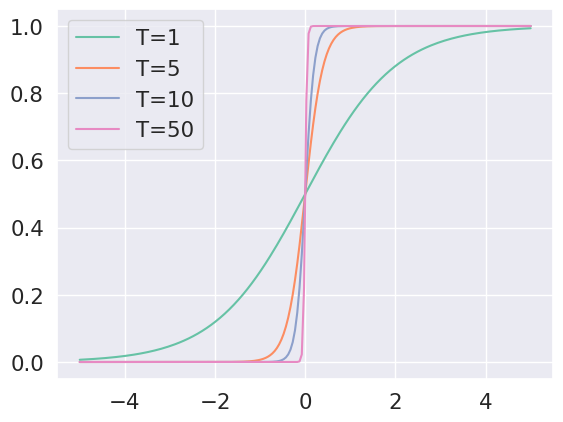

In [44]:
grid = torch.linspace(-5, 5, 200)
temperatures = [1, 5, 10, 50]
for temp in temperatures:
    plt.plot(grid, tempered_sigmoid(grid, temp), label=f'T={temp}')
plt.legend()
plt.show()

Сравним эти функции активации с еще тремя, которые были у вас на лекции: `ReLU`, `LeakyReLU`, `GELU`. У каждой зададим `learning_rate`.

In [45]:
activation_functions = {
    'Индикатор': [Indicator(), 0.01],
    'Сигмоида (t)': [TemperedSigmoid(), 0.01],
    'ReLU     ': [nn.ReLU(), 0.1],
    'LeakyReLU': [nn.LeakyReLU(), 0.1],
    'GELU     ': [nn.GELU(), 0.1]
}

Инициализируйте и обучите модель с каждой функцией активации 5 раз, и выберете лучшее предсказание по MSE. Построим график с лучшим предсказанием для каждой функции активации. Сравните эти предсказания между собой по MSE. Отличаются ли предсказания в случаях индикаторной функции и сигмоиды?

Индикатор 	 0.1915
Сигмоида (t) 	 0.2017
ReLU      	 0.1261
LeakyReLU 	 0.118
GELU      	 0.1268


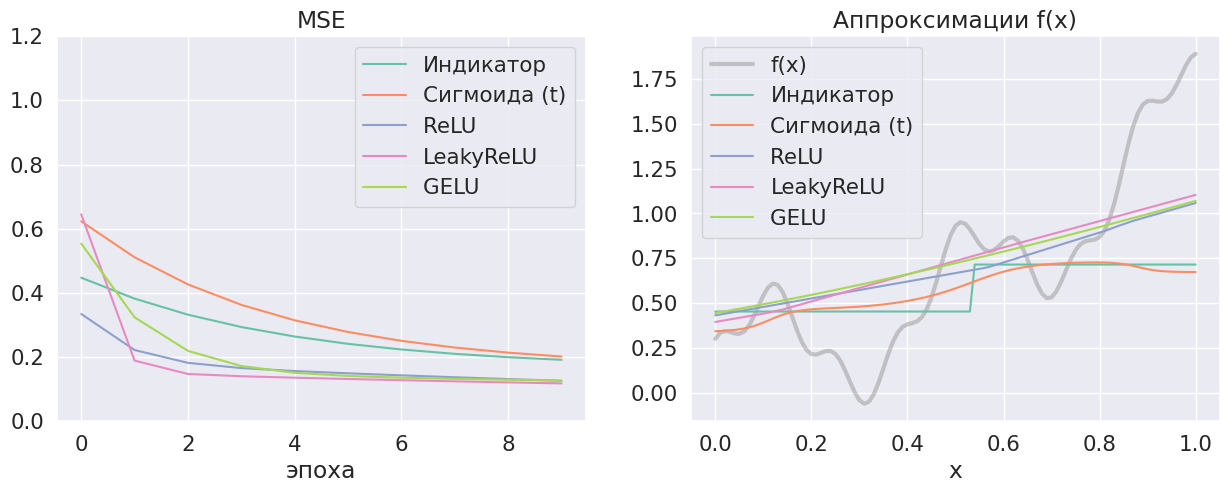

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[1].plot(x.ravel(), y_true.ravel(), label='f(x)',
            color='grey', lw=3, alpha=.4)

n_times = 5
n_epochs = 10
for name, (func, lr) in activation_functions.items():
    MSEs = []
    y_preds = []
    for i in range(n_times):
        model = MyModel(n_hidden=10, activation=func)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        loss_history = train(model, optimizer, mse, x, y_true, n_epochs)
        y_pred = eval(model, x)
        MSEs.append(loss_history["loss"].copy())
        y_preds.append(y_pred.ravel().detach())
    MSEs = np.array(MSEs)
    best = np.nanargmin(MSEs[:, -1])
    print(name, '\t', np.round(MSEs[best][-1], 4))

    axs[0].plot(MSEs[best], label=name)
    axs[1].plot(x.ravel(), y_preds[best].ravel(), label=name)

axs[0].legend()
axs[1].legend()
axs[0].set_title('MSE')
axs[1].set_title('Аппроксимации f(x)')
axs[0].set_xlabel('эпоха')
axs[1].set_xlabel('x')
axs[0].set_ylim(0, 1.2)

plt.show()

**Ответ:**

Как видим, лучший результат показывают GELU, LeakyReLU и ReLU.

В данном примере оказалось, что индикаторная функция подходит под функцию активации лучше, чем сигмоида. Впрочем, это во многом зависит от sgd. При перегенерации часто случалось, что сигмоида была не сильно лучше или хуже индикатора.

Вернемся к индикаторной функции активации. Исследуйте то, как обучается модель в зависимости от ширины первого слоя (ширина = кол-во нейронов). Рассмотрим значения 5, 10, 20, 50, 100.  Теперь будем запускать инициализацию по 100 раз. Не беспокойтесь, считается довольно шустро. Для каждой ширины слоя, построим графики зависимости функции ошибки от эпохи обучения. Также построим график среднего предсказания с доверительным интервалом ширины $2\sigma$ (здесь корень из дисперсии), сравните его с $f(x)$. Сделайте выводы.

In [47]:
n_times = 100

In [57]:
def test_different_hidden_sizes(activation_function):
    sns.set_style("whitegrid")
    for n_hidden in (5, 10, 20, 50, 100):
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        y_preds = []
        MSEs = []

        for i in range(n_times):
            model = MyModel(n_hidden = n_hidden, activation=activation_function)
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
            loss_history = train(model, optimizer, mse, x, y_true, n_epochs)
            y_pred = model.eval(x)
            MSEs.append(loss_history["loss"].copy())
            y_preds.append(y_pred.ravel().detach())
            axs[0].plot(loss_history["loss"], color='blue', alpha=0.1)

        # предсказания, их средние и стандартное отклонение
        y_preds = torch.stack(y_preds)
        y_pred_mean = torch.mean(y_preds, dim=0)
        y_pred_std = torch.std(y_preds, dim=0)

        axs[1].plot(x, y_pred_mean, color='blue', label='среднее предсказ.')
        axs[1].fill_between(
            x.ravel(), y_pred_mean - y_pred_std * 2, y_pred_mean + y_pred_std * 2,
            alpha=0.1, color='blue', label='дов. интервал')
        axs[1].plot(x.ravel(), y_true.ravel(), label='f(x)', color='#00BB99', lw=3)

        mse_mean = torch.mean(torch.tensor(MSEs))

        axs[1].legend()
        axs[0].set_title(f'MSE ~ {mse_mean:.2f}')
        axs[1].set_title('Аппроксимации f(x)')
        axs[0].set_xlabel('эпоха')
        axs[1].set_xlabel('x')
        axs[0].set_ylim(0, 1.2)

        fig.suptitle(f'{n_hidden} нейронов в 1-м слое')
        plt.show()

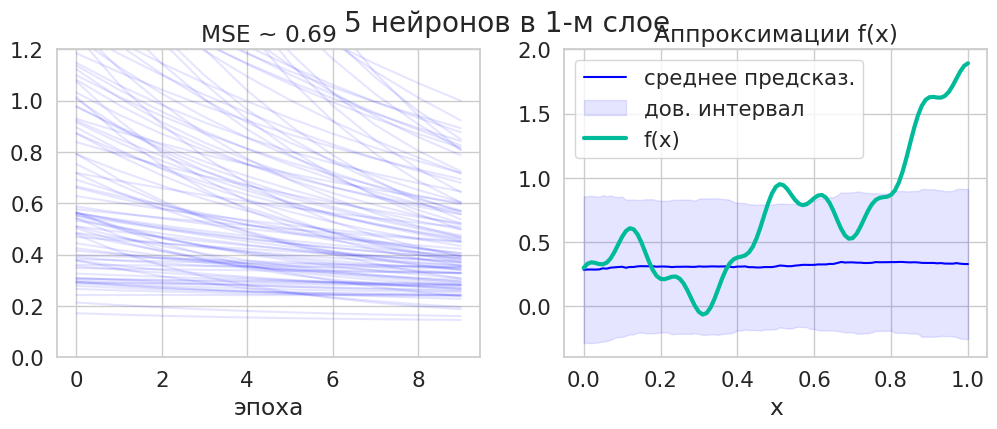

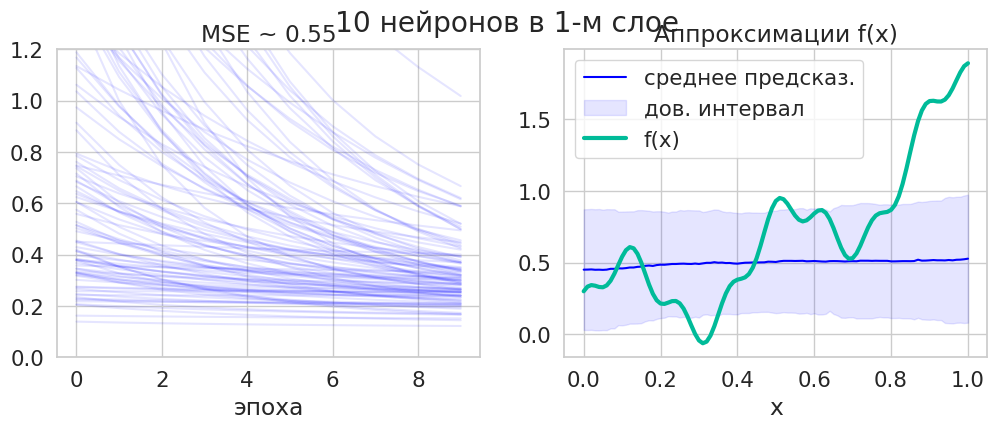

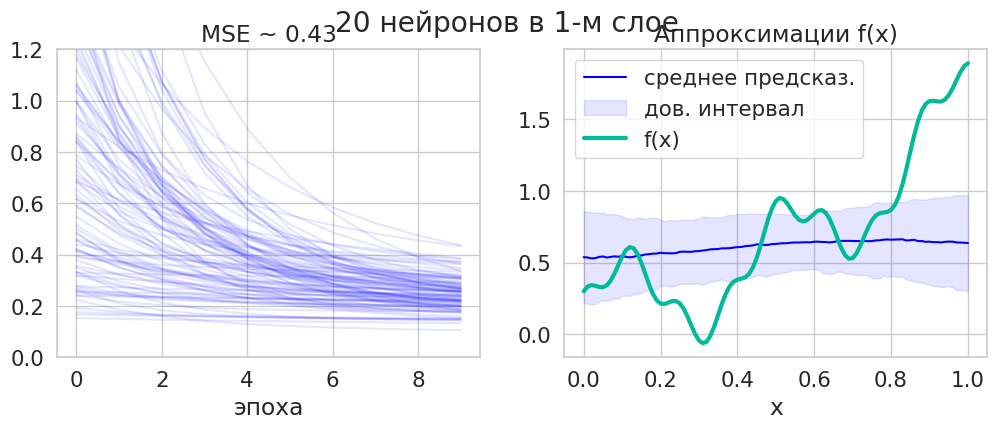

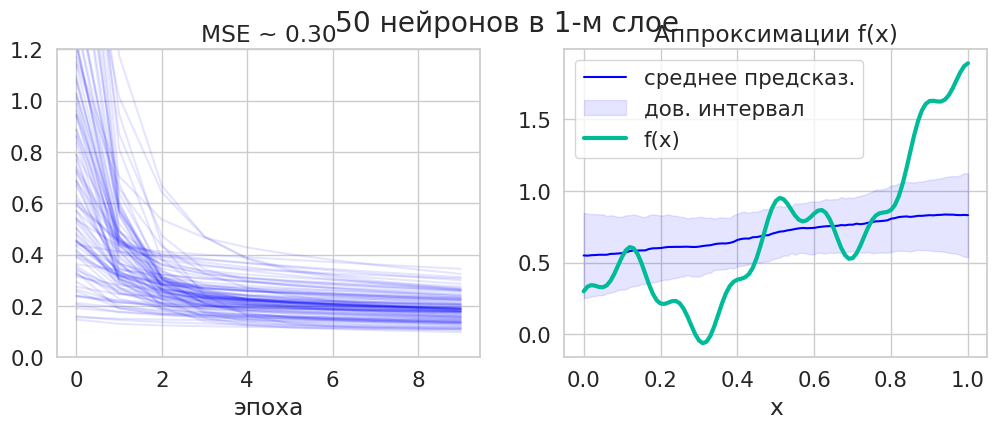

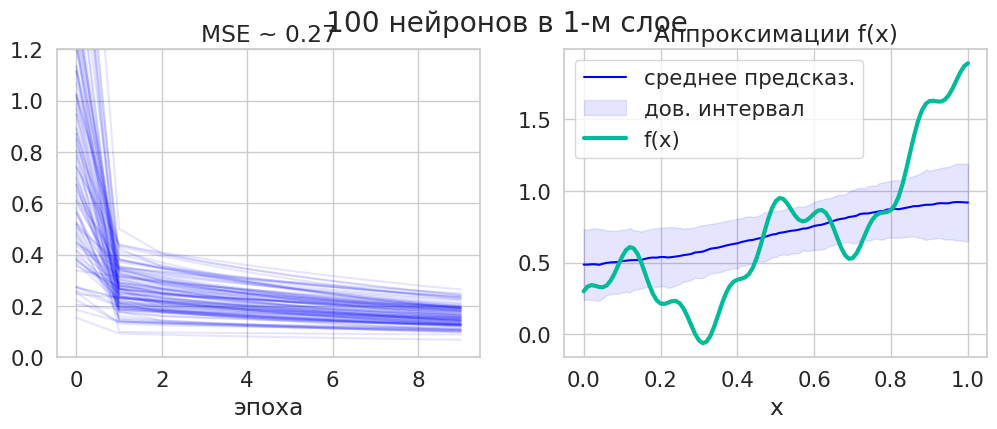

In [58]:
test_different_hidden_sizes(Indicator())

Повторите то же самое для функции активации ReLU. Сделайте выводы.

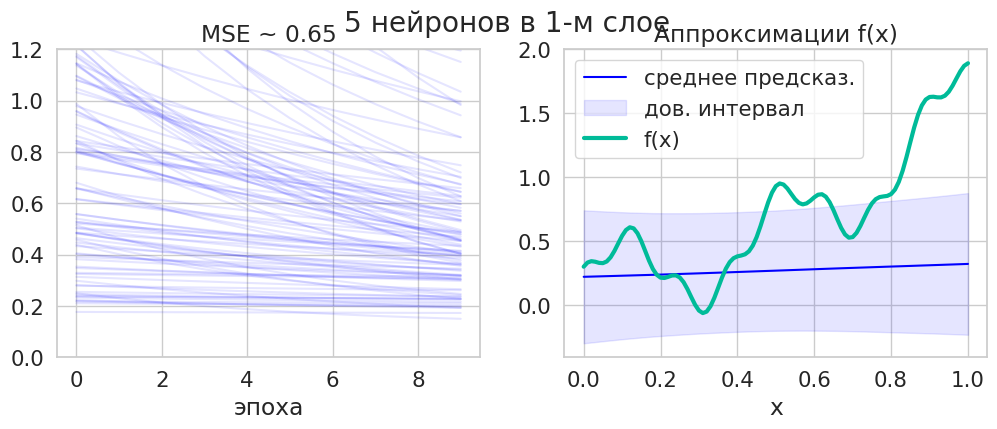

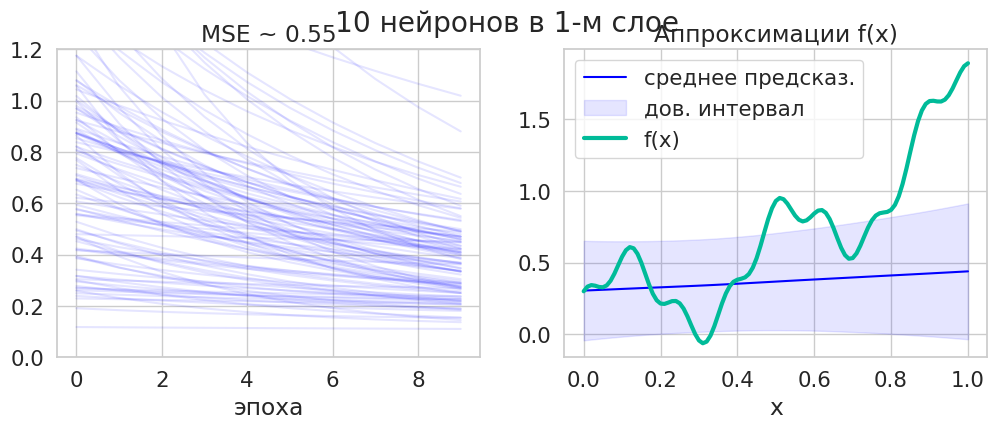

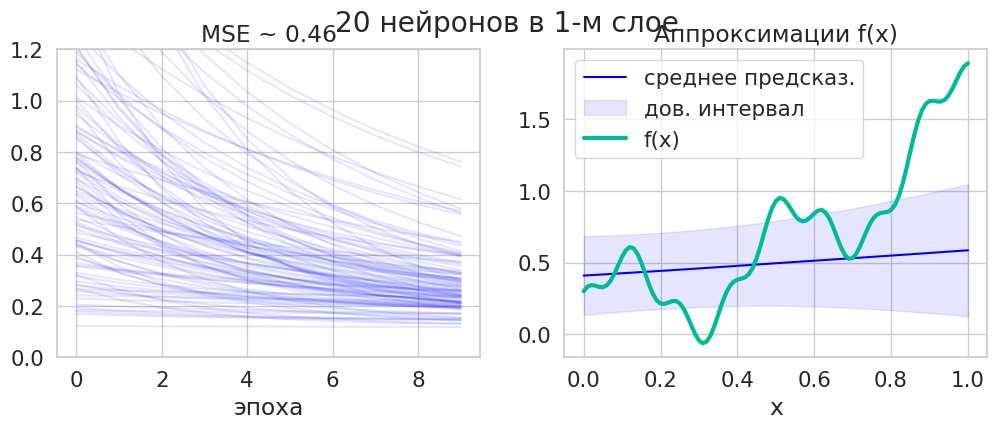

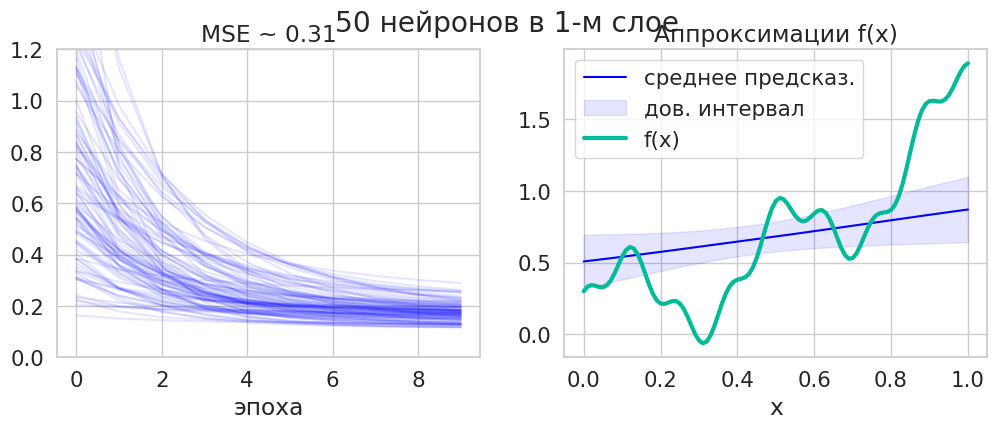

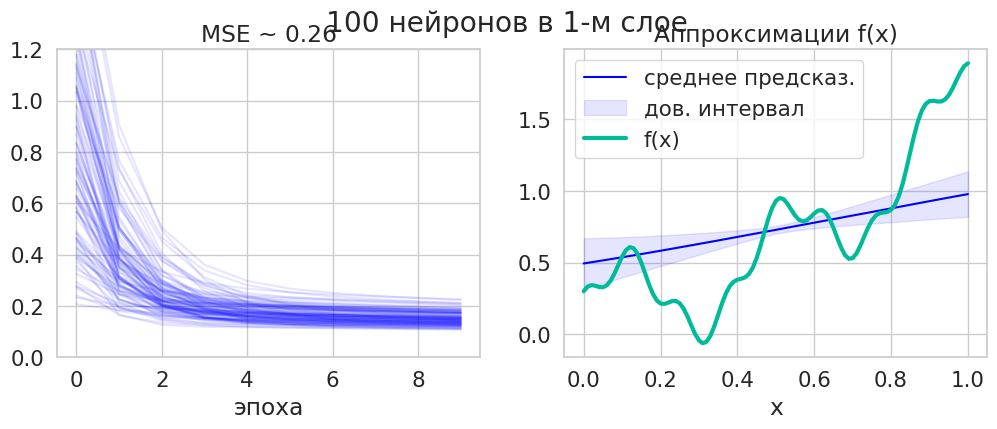

In [59]:
test_different_hidden_sizes(nn.ReLU())

**Ответ:** В обоих случаях среднее с увеличением числа нейронов начинает повторять тренд исследуемой функции. Заметим, что доверительный интервал полученный для ReLU оказался уже, чем для индикатора. Также отметим, что ни один доверительный интервал не покрывает достаточно хорошо исследуемую функцию.

**Вывод**

* Сравнили различные виды активирующих функций, в нашем случае оказалось, что лучшими будут ReLU и ее модификации.

* Заметили, что если поставить в финальный слой тождественную функцию активации, то веса обучаться не будут.

* Увидили, что с увеличением числа нейронов среднее повторяет тренд основной функции, а д.и. сужается.

* Увидили, что с увеличением числа нейронов падает лосс.